# GeoGraph Tutorial

In this tutorial we will go through the `geograph` package and discuss a couple of common use cases and operations.

## 1. Setup

## 1.1 Installation

To get started, you will need to make sure that you have `geograph` installed. If you
are using this tutorial via the binder link, then `geograph` will already be installed.

If you have not yet installed `geograph` you can install it via
```
pip install geograph
```

## 1.2 Imports

Now that we have `geograph` installed, let us import the main module.

We will also be loading data from two datasets, the `Polesia` and `Chernobyl` datasets. If you are 
working on binder, this data will already be downloaded for you. If you are working locally, you 
can download the data from this dropbox link [here](https://www.dropbox.com/s/ghcf4q447nxddy5/binder_data.zip?dl=1).

In [2]:
# general imports
import pandas as pd      # for dealing with tabular data
import geopandas as gpd  # for dealing with vector data
import rioxarray as rxr  # for dealing with raster data

# geograph imports
import geograph
from geograph import geotimeline
from geograph.visualisation import geoviewer
from geograph.constants import UTM35N
from geograph.metrics import LANDSCAPE_METRICS_DICT, COMPONENT_METRICS_DICT

# data imports (works on th binder only)
#  if you are not working on binder, import the data from: 
#  https://www.dropbox.com/s/ghcf4q447nxddy5/binder_data.zip?dl=1
from geograph.demo.binder_constants import DATA_DIR, ROIS, ESA_CCI_LEGEND_LINK

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## 2. Analysis of ground survey data and landscape metrics

For this section, we will be working with the `Polesia` dataset, which was created by Dmitri Grummo, for the [Endangered Landscapes Program](https://www.endangeredlandscapes.org/) and was funded by Arcadia, a charitable fund of Lisbet Rausing and Peter Baldwin.

The data we use here is a subset of the full dataset collected by Dmitri Grummo. It combines ground surveys and remote sensing to create a high quality land cover map with ecologically relevant land cover classes for the Polesia zone.
The data is collected in the `WGS84 UTM35` coordinate reference system.

Let us load the data and inspect it briefly.

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Number of patches in region of interest: 323


,OBJECTID,N_Eunis,Eunis_name,Shape_Leng,Shape_Area,Leg,AREA,geometry
0,65,D1.11,"Active, relatively undamaged raised bogs",3244.211911,3.767096e+05,2,37.6710,"POLYGON Z ((522663.501 5717738.222 0.000, 5227..."
1,67,D1.11,"Active, relatively undamaged raised bogs",2970.146257,3.165971e+05,2,31.6597,"POLYGON Z ((525143.664 5719878.230 0.000, 5252..."
2,68,D1.11,"Active, relatively undamaged raised bogs",2182.893205,2.663976e+05,2,26.6398,"POLYGON Z ((521759.472 5720117.848 0.000, 5221..."
3,69,D1.11,"Active, relatively undamaged raised bogs",3881.473848,4.075725e+05,2,40.7573,"POLYGON Z ((519901.603 5719846.246 0.000, 5198..."
4,70,D1.11,"Active, relatively undamaged raised bogs",6549.770969,1.363278e+06,2,136.3280,"POLYGON Z ((530088.099 5720147.705 0.000, 5300..."


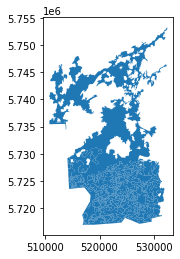

In [3]:
from geograph.demo.binder_constants import DATA_DIR  # change this if you work locally
import geopandas as gpd

# Loading Polesia data 
polesia_dataset_path = DATA_DIR / "polesia" / "polesia_landcover_sample.gpkg"
polesia_dataset = gpd.read_file(polesia_dataset_path)

# Displaying the polesia data
print("Number of patches in region of interest:", len(polesia_dataset))
polesia_dataset.plot()
polesia_dataset.head(5)

## 2.1 Creating a GeoGraph

To use the tools in the `geograph` package, the first step is to create a `GeoGraph` from
the given data. A `GeoGraph` is the central object of analysis within `geograph`. 
`GeoGraph` will automatically detect whether it is reading vector or raster
data and create the graph for the landscape accordingly.

Here's how you can create a `GeoGraph`: 

In [4]:
import geograph
from geograph.constants import UTM35N

# Building the main graph structure
polesia_graph = geograph.GeoGraph(polesia_dataset, 
  crs=UTM35N,  # Provide the coordinate reference system of the data
  columns_to_rename={"Eunis_name":"class_label",  # tell GeoGraph which variable should be used as class_label
                     "AREA":"area"}
 )

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 323/323 [00:04<00:00, 70.70it/s] 
Step 2 of 2: Adding edges: 100%|██████████| 323/323 [00:00<00:00, 59712.63it/s]

Graph successfully loaded with 323 nodes and 816 edges.


Note that we renamed the column `Eunis_name` to `class_label`. The name `class_label` is used
internally in `GeoGraph` to denote the land cover class of a patch in the graph. This renaming
is needed to help the Graph understand which column contains the relevant land cover information.

## 2.2 Visualising the GeoGraph

Next, we can visualise the graph that we just created to make sure that it makes 
sense and to learn more about our data.

### 2.2.1 A first visualisation for quick inspection

To do so, `geograph` comes shipped with a `visualisation` module that will allow you
to interactively look at your data.

In [5]:
from geograph.visualisation import geoviewer  # geograph visualisation module
import ipyleaflet  # for satellite basemap

viewer = geoviewer.GeoGraphViewer(small_screen=True)
viewer.add_layer(ipyleaflet.basemaps.Esri.WorldImagery)
viewer.add_graph(polesia_graph, name='Polesia data')
viewer.enable_graph_controls()
viewer

Constructing graph: 100%|██████████| 1/1 [00:00<00:00, 1004.86it/s]


GeoGraphViewer(center=[51.389167, 30.099444], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

By hovering over a patch of landcover in the graph, you will get more detailed information 
about that patch and several key patch metrics:
- `land cover class`
- `area`
- `perimeter` 
- `shape_index`
- `fractal_dimension`

If you switch to the metrics tab in the top right control panel, you will also see a couple of aggregated landscape and graph based
metrics that are available to you to better understand the landscape at hand. By default, `geograph` computes
only a minimum amount of aggregated metrics. But many more are available.

### 2.2.2 Adding further metrics

To see further metrics which are available, we can have at the `geograph` metrics module:



In [6]:
from geograph.metrics import LANDSCAPE_METRICS_DICT, COMPONENT_METRICS_DICT

available_metrics = list(LANDSCAPE_METRICS_DICT.keys()) + list(COMPONENT_METRICS_DICT.keys())
print(f"Available aggregated metrics: \n\n{available_metrics}")

Available aggregated metrics: 

['avg_patch_area', 'total_area', 'num_patches', 'patch_density', 'largest_patch_index', 'shannon_diversity_index', 'simpson_diversity_index', 'num_components', 'avg_component_area', 'avg_component_isolation']


If we wanted to include all these metrics in the visualisation, we can simply pass them to the `GeoGraphViewer`:

In [7]:
viewer = geoviewer.GeoGraphViewer(small_screen=True, metric_list=available_metrics)
viewer.add_layer(ipyleaflet.basemaps.Esri.WorldImagery)
viewer.add_graph(polesia_graph, name='Polesia data', with_components=True)
viewer.enable_graph_controls()
viewer

Constructing graph: 100%|██████████| 1/1 [00:00<00:00, 1140.07it/s]


Calculating component polygons...


Constructing graph: 100%|██████████| 1/1 [00:00<00:00, 1129.32it/s]


              than ~100 components.


Constructing graph: 100%|██████████| 1/1 [00:00<00:00, 892.03it/s]
Calculating edge weights: 0it [00:00, ?it/s]


GeoGraphViewer(center=[51.389167, 30.099444], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

## 2.3 Working with habitats

A key feature of `geograph` is that it can combine a couple of land cover classes 
together with a prescribed maximal travel distance to form a habitat. Let us see how we can use `geograph` to analyse habitats for different species.


We define a `habitat` as a subset of land cover classes from the full data set, together with a travel distance of how far a species of interest is likely to travel outside it’s natural habitat. Such information can be obtained for example from species databases. 

For the demo purposes, let us selected all sub-classes of pine forests as habitat for an imaginary species here. Note however, that this could be any subset of land cover classes.


### 2.3.1 Constructing habitats

In [8]:
# First selecting the classes that make up our habitat
# We chose all classes with 'pine' in the name.
pine_classes = [label for label in polesia_graph.df.class_label.unique() if 'pine' in label]
pine_classes

['Subcontinental moss Scots pine forests',
 'Subcontinental lichen Scots pine forests',
 'Subcontinental moorgrass Scots pine forests',
 'Boreal Labrador tea Scots pine bog woods',
 'Boreal cottonsedge Scots pine bog woods',
 'Boreal neutrocline sphagnum Scots pine fen woods',
 'Mixed Scots pine-birch woodland']

We will look at three different species which live in pine forests and differ only by their maximal travel distance outside the pine forests. We’ve  added three different maximal travel distances of 5, 25 and 500m that correspond to imaginary sessile, semi-mobile and mobile species.

In [9]:
# Next, we create three different species which can live in pine forests
# and travel outside of pine forests for different distances
# Distances: mobile (<500m), semi mobile (<25m) and sessile (<5m) 
# (proposed by Adham Ashton-Butt at BTO)
polesia_graph.add_habitat('Sessile', 
                  max_travel_distance=5, 
                  valid_classes=pine_classes)

polesia_graph.add_habitat('Semi mobile', 
                  max_travel_distance=25, 
                  valid_classes=pine_classes)

polesia_graph.add_habitat('Mobile',
                  max_travel_distance=500, 
                  valid_classes=pine_classes)

Generating habitat graph: 100%|██████████| 95/95 [00:00<00:00, 731.65it/s]


Calculating components...


Constructing graph: 100%|██████████| 39/39 [00:00<00:00, 9367.65it/s]



Habitat successfully loaded with 95 nodes and 78 edges.


Generating habitat graph: 100%|██████████| 95/95 [00:00<00:00, 709.01it/s]


Calculating components...


Constructing graph: 100%|██████████| 36/36 [00:00<00:00, 10528.17it/s]



Habitat successfully loaded with 95 nodes and 86 edges.


Generating habitat graph: 100%|██████████| 95/95 [00:00<00:00, 751.45it/s]


Calculating components...


Constructing graph: 100%|██████████| 14/14 [00:00<00:00, 6468.41it/s]


Habitat successfully loaded with 95 nodes and 214 edges.


When a habitat is added, GeoGraph computes a reduced graph from the full graph. It identifies connected habitat components, given the maximal travel distance. Connected components of a habitat are collections of land cover patches that an animal can reach within its maximal travel distance outside its habitat.


### 2.3.2 Visualising habitats



We can now go ahead an visualise these habitats in the `GeoGraphViewer` to understand the habitats better.
The visualisation allows us to quickly identify isolated or patches, or patches that might easily become detached and need special policy attention. By doing so, it gives us valuable information about habitat fragmentation.

As we look at the more and more mobile species, we see that their habitat becomes more and more connected.

By going to the metrics tab we can again see some key metrics for this particular habitat. For large scale analyses these metrics are also accessible directly in code, without having to go via the interactive visualisation (see section 2.4 below).


In [10]:
viewer = geoviewer.GeoGraphViewer(small_screen=True, metrics=available_metrics)
viewer.add_layer(ipyleaflet.basemaps.Esri.WorldImagery)
viewer.add_graph(polesia_graph, name='Polesia data', with_components=True)
viewer.enable_graph_controls()
viewer

Constructing graph: 100%|██████████| 14/14 [00:00<00:00, 5017.97it/s]


GeoGraphViewer(center=[51.389167, 30.099444], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

We envision that the `habitat` functionality of geograph might help us recommend valuable regions for conservation of a species of interest based on maximizing habitat connectivity.

In this particular example, adding a protected area in the bottom left region would connect three previously unconnected habitat components for the mobile species. And connecting multiple components would increase the effective habitat size for our species of interest. This increase in habitat size might have a positive impact on the species. 
Obviously, many more factors would go into an actual decision, but the key idea here is that the graph based formulation and definition of `habitats` may be able to help us make an initial recommendation.


## 2.4 Computationally analysing the GeoGraph

The visualisations above are a great way to familiarise yourself with the data and
to present them to others.

For some applications however, you need the metrics available in `GeoGraph` for extra
computations or generating custom visualisations. 

Below, we will show how you can easily access the patch, class and 
landscape level metrics from `GeoGraph` via code and have them returned to you as 
`pandas` dataframes.



In [11]:
# Compute all patch level metrics
polesia_graph.get_patch_metrics()  # Note: Area and perimeter are in the units of the underlying CRS

,class_label,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension
node_index,,,,,,
0,"Active, relatively undamaged raised bogs",3.767096e+05,3244.211911,0.008612,1.321435,1.043417
1,"Active, relatively undamaged raised bogs",3.165971e+05,2970.146257,0.009381,1.319667,1.043801
2,"Active, relatively undamaged raised bogs",2.663976e+05,2182.893205,0.008194,1.057322,1.008923
3,"Active, relatively undamaged raised bogs",4.075725e+05,3881.473848,0.009523,1.519967,1.064823
4,"Active, relatively undamaged raised bogs",1.363278e+06,6549.770969,0.004804,1.402407,1.047884
...,...,...,...,...,...,...
318,"Recently felled areas, formerly mixed broadlea...",4.624960e+04,1379.683795,0.029831,1.603857,1.087957
319,"Recently felled areas, formerly mixed broadlea...",5.069803e+04,1091.917966,0.021538,1.212368,1.035551
320,"Recently felled areas, formerly mixed broadlea...",2.063375e+05,3544.803776,0.017180,1.950937,1.109225


Note here that `area` and `perimeter` are in the units of the underlying CRS. In our case this is `UTM35N`, which
has the units of metre (`m`).

In [12]:
# Compute all class metrics
#  specific metrics or metrics only for specific classes can be computed by providing
#  the additional `names` and `classes` parameters to the `.get_class_metrics()` method.
polesia_graph.get_class_metrics()

,num_patches,avg_patch_area,total_area,proportion_of_landscape,patch_density,largest_patch_index,total_edge,edge_density,shape_index,effective_mesh_size
"Active, relatively undamaged raised bogs",10,8.636351e+05,8.636351e+06,0.025815,2.989124e-08,0.011702,58761.195347,0.006804,4.998797,6.013801e+04
Beds of large sedges normally without free-standing water,17,1.112501e+07,1.891252e+08,0.565319,5.081511e-08,0.526203,718163.904809,0.003797,13.055362,9.269465e+07
Boreal Labrador tea Scots pine bog woods,6,6.688350e+05,4.013010e+06,0.011995,1.793475e-08,0.004076,34448.851308,0.008584,4.299121,1.115717e+04
Boreal cottonsedge Scots pine bog woods,24,4.000696e+05,9.601670e+06,0.028701,7.173898e-08,0.004115,93659.084467,0.009754,7.556428,2.109696e+04
Boreal neutrocline sphagnum Scots pine fen woods,6,5.878279e+05,3.526968e+06,0.010543,1.793475e-08,0.006394,28029.206581,0.007947,3.731213,1.537939e+04
Coniferous scrub woodland,2,7.336898e+04,1.467380e+05,0.000439,5.978248e-09,0.000266,3159.300572,0.021530,2.061863,3.367067e+01
Deciduous scrub woodland,5,2.208029e+05,1.104015e+06,0.003300,1.494562e-08,0.002016,11834.862516,0.010720,2.815891,1.528313e+03
Grey willow carrs,7,2.808792e+05,1.966155e+06,0.005877,2.092387e-08,0.002849,22848.391758,0.011621,4.073679,4.039706e+03
Meso-acidophilous birch swamp woods,16,3.130769e+05,5.009231e+06,0.014973,4.782599e-08,0.002956,61571.026496,0.012292,6.877504,7.953098e+03
Mixed Scots pine-birch woodland,1,1.497235e+05,1.497235e+05,0.000448,2.989124e-09,0.000448,2636.675623,0.017610,1.703538,6.700758e+01


Individual metrics can also be accessed directly via the `.get_metric()` method.
This method gives some additional information including the units of the metric as well
as a description about the metric.

Let's try it out for the example of the Shannon Diversity index.

In [13]:
polesia_graph.get_metric("shannon_diversity_index")

Metric(value=1.741715482112242, name='shannon_diversity_index', description='SHDI approaches 0 when the entire landscape consists of a single patch, and increases as the number of classes increases and/or the proportional distribution of area among classes becomes more equitable.', variant='conventional', unit='dimensionless')

## 3. Analysis of landscape changes

In this second part of the tutorial we will go through an example of how `geograph` can be
used to analyse data that has been collected for the same region for several years.

As an example, we will use raster land cover data from the European Space Agency's climate
change initiative (ESA CCI). The [ESA CCI land cover](http://www.esa-landcover-cci.org/) initiative created yearly land cover maps at a resolution of 300m around the globe for the years 1990 to 2015.
Specifically, we will look at the years 2013 and 2014 for the [Chernobyl exclusion zone](https://en.wikipedia.org/wiki/Chernobyl_Exclusion_Zone), which has
seen rewilding after the nuclear catastrophe in 1986.

All data comes pre-installed on the binder in the `DATA_DIR` that we imported from the `binder_constants`. If you are following this demo on your local machine, you can download the data with [this link](https://www.dropbox.com/s/ghcf4q447nxddy5/binder_data.zip?dl=1).

## 3.1 Loading the raster data

In [14]:
import rioxarray as rxr

# Parse geotif landcover data
chernobyl_path = lambda year: DATA_DIR / "chernobyl" / "esa_cci" / f"esa_cci_{year}_chernobyl.tif" 

# Parse ROIS
rois = gpd.read_file(ROIS)
# Load the shape of the chernobyl exclusion zone
cez = rois[rois["name"] == "Chernobyl Exclusion Zone"]
cez

,name,area (km2),geometry
3,Chernobyl Exclusion Zone,2597.858793,GEOMETRYCOLLECTION (MULTIPOLYGON (((29.26795 5...


In [15]:
def clip_and_reproject(xrdata, clip_geometry=None, to_crs=UTM35N, x_res=300, y_res=300):
    
    if clip_geometry is not None:
        clipped_data = xrdata.rio.clip(clip_geometry)
    else:
        clipped_data = xrdata
        
    if to_crs is not None:
        reprojected_data = clipped_data.rio.reproject(to_crs, resolution=(x_res, y_res))
    else:
        reprojected_data = clipped_data
    
    return reprojected_data

Next, let us open the relevant ESA CCI raster data for Chernobyl and clip and reproject them to the correct CRS
for the region.

In [16]:
# Loading ESA CCI land cover raster data
years = list(range(2013,2015))
cez_rasters = {year: clip_and_reproject(rxr.open_rasterio(chernobyl_path(year)), clip_geometry=cez.geometry) 
              for year in years
             }

We will also load the ESA CCI land cover labels to interpret the classification.

In [17]:
# Loading ESA CCI land cover legend to translate land cover labels to classes
esa_cci_legend = pd.read_csv(ESA_CCI_LEGEND_LINK, delimiter=";", index_col=0)
print(f"There are {len(esa_cci_legend)} classes.")

class_value_to_label = {class_val: row.LCCOwnLabel for class_val, row in esa_cci_legend.iterrows()}

There are 38 classes.


## 3.2 Creating the GeoGraph

In [18]:
# Polygonising raster and transforming into graph
cez_graphs = {}
for year, raster in cez_rasters.items():
    print(f"Analysing year {year}")
    # Load geograph from the raster data (construction takes ~10s)
    cez_graphs[year] = geograph.GeoGraph(data=raster.data, 
                                transform=raster.rio.transform(), 
                                crs=UTM35N, 
                                mask = raster.data > 0,
                                connectivity=8)
    # Map the ESA CCI land cover class value (int) to the plain text label
    #  to have the plain text labels available in the interactive viewer.
    cez_graphs[year].df.class_label = cez_graphs[year].df.class_label.apply(lambda x: class_value_to_label[x])

Analysing year 2013


Identifying nodes: 100%|██████████| 2923/2923 [00:05<00:00, 517.57it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2003/2003 [00:10<00:00, 183.85it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2003/2003 [00:00<00:00, 58508.60it/s]


Graph successfully loaded with 2003 nodes and 5140 edges.
Analysing year 2014


Identifying nodes: 100%|██████████| 2915/2915 [00:05<00:00, 512.30it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1999/1999 [00:11<00:00, 176.44it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1999/1999 [00:00<00:00, 56989.14it/s]

Graph successfully loaded with 1999 nodes and 5117 edges.


## 3.3 Identifying corresponding nodes

In [19]:
cez_timeline = geotimeline.GeoGraphTimeline(cez_graphs)
# Perform node identification
cez_timeline.timestack()
# Classify node dynamics for the year 2014
cez_timeline.calculate_node_dynamics(2014);

Identifying nodes: 100%|██████████| 2003/2003 [00:03<00:00, 502.23it/s]


In [20]:
# Build up the viewer
viewer = geoviewer.GeoGraphViewer(small_screen=True, metric_list=available_metrics)
viewer.add_layer(ipyleaflet.basemaps.Esri.WorldImagery)
viewer.add_graph(cez_timeline[2014], name='Chernobyl data', with_components=False)
viewer.enable_graph_controls()

Calculating component polygons...


Constructing graph: 100%|██████████| 1/1 [00:00<00:00, 1073.54it/s]


              than ~100 components.


Constructing graph: 100%|██████████| 1/1 [00:00<00:00, 2718.28it/s]
Calculating edge weights: 0it [00:00, ?it/s]


In [21]:
# Display the interactive map
viewer

GeoGraphViewer(center=[51.389167, 30.099444], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In addition to the patch metrics of landscape ecology that we saw earlier, you can now also see information about a node’s behaviour in the monitoring time period in the panel on the bottom right. We can also toggle and overview of the node dynamics to see what type of change different nodes are undergoing, or look at the absolute node growth like this.

This allows us to spatially resolve whether individual habitats are shrinking, growing, merging or splitting. It allows us to track how habitat fragmentation changes over the course of time.
